In [1]:
from unityagents import UnityEnvironment
import numpy as np
import time
import random
import torch
from ddpg import Agent

import matplotlib.pyplot as plt
%matplotlib inline

seed = 0

random.seed(seed)
torch.manual_seed(seed)

## Environment

In this environment, a double-jointed arm can move to target locations. A reward of +0.1 is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of 33 variables corresponding to position, rotation, velocity, and angular velocities of the arm. Each action is a vector with four numbers, corresponding to torque applicable to two joints. Every entry in the action vector must be a number between -1 and 1.

We are doing the 2nd version of the project, which contains 20 identical agents, each with its own copy of the environment.

Run the code cell below to print some information about the environment.

In [2]:
env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher.exe')
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


## RL Agent & Model

### Model
model: ddpg/model.py
model.py contains two neural network model, a actor network and a critic network. 

#### The actor network
The actor network is a 3-layers fully-connected neural network of size (400x300x4) with a batch normalization layer. The actor network takes a state (of size 33) and output an action. 

#### The critic network
The critic network is a 3-layers fully-connected neural network of size (400x(300+4)x1) with a batch normalization layer. The critic network takes a state 's' (of size 33) and an action 'a' (of size 4) and approximate the q-value Q(s,a). 

### Agents
We implement a ddpg agent (ddpg/agent.py) which use two networks (actor and critic) to learn the optimal policy. 
At every time step, all 20 agents collect experiences and add them to one shared memory buffer. After every 20 time-steps, we then let the agent do the network update 10 times (from 10 different sample from the memory buffer). To prevent gradient explosion, we use gradient clipping on the critic network. We also turn off the noise parameters. 

The hyper-paremeters are as followed:

- BUFFER_SIZE = int(1e6)
- BATCH_SIZE = 512
- GAMMA = 0.99 # the discount factor
- TAU = 1e-3       # the soft-update parameter
- LR_ACTOR = 1e-3  # the learning rate of the actor 
- LR_CRITIC = 1e-3 # the learning rate of the critic  

In [4]:
def run_episode(env, brain_name, agent, max_t=1000, update_freq=20, num_updates=10):
    env_info = env.reset(train_mode=True)[brain_name]     # reset the environment
    states   = env_info.vector_observations               # get the current state (for each agent)
    agent.reset()

    num_agents = len(env_info.agents)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    for t in range(max_t):
        actions     = agent.act(states, add_noise=False)
        env_info    = env.step(actions)[brain_name] 
        
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards     = env_info.rewards                     # get reward (for each agent)
        dones       = env_info.local_done                  # see if episode finished

        for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            agent.add_experience(state, action, reward, next_state, done)
                
        if (t % update_freq) == 0:
            for i in range(num_updates):
                agent.learn()
        
        states  = next_states                               # roll over states to next time step
        scores += rewards
        if np.any(dones):
            break 

    return scores

In [5]:
agent = Agent(state_size=state_size, action_size=action_size)

In [6]:
scores = []
for i in range(200):
    all_agent_scores = run_episode(env, brain_name, agent)
    epi_score = np.mean(all_agent_scores)
    scores += [epi_score]
    
    if (i % 2) == 0:
        print('\r%d: Episode Score: [%.2f]\tAvg Score: [%.2f]' % (i, epi_score, np.mean(scores[-100:])))

0: Episode Score: [0.45]	Avg Score: [0.45]
2: Episode Score: [0.60]	Avg Score: [0.48]
4: Episode Score: [0.57]	Avg Score: [0.53]
6: Episode Score: [1.18]	Avg Score: [0.67]
8: Episode Score: [1.51]	Avg Score: [0.81]
10: Episode Score: [2.79]	Avg Score: [1.10]
12: Episode Score: [2.81]	Avg Score: [1.37]
14: Episode Score: [3.77]	Avg Score: [1.66]
16: Episode Score: [6.65]	Avg Score: [2.15]
18: Episode Score: [14.57]	Avg Score: [3.14]
20: Episode Score: [21.18]	Avg Score: [4.52]
22: Episode Score: [30.06]	Avg Score: [6.56]
24: Episode Score: [32.46]	Avg Score: [8.57]
26: Episode Score: [35.65]	Avg Score: [10.55]
28: Episode Score: [35.82]	Avg Score: [12.32]
30: Episode Score: [36.67]	Avg Score: [13.83]
32: Episode Score: [39.25]	Avg Score: [15.34]
34: Episode Score: [39.22]	Avg Score: [16.69]
36: Episode Score: [39.24]	Avg Score: [17.90]
38: Episode Score: [39.31]	Avg Score: [19.00]
40: Episode Score: [39.52]	Avg Score: [20.00]
42: Episode Score: [39.49]	Avg Score: [20.90]
44: Episode Sco

In [7]:
# save parameters
agent.save_model('model/actor.pt', 'model/critic.pt')

## Training Performance

Our agent can solve the environment after 23 episodes (the average scores of 20 agents is 30+). And the performance of the agent remain above 30+ from the 22th episode onward (upto the 200th episode).

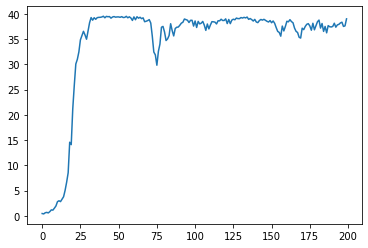

In [9]:
# plot rewards score over 200 episodes
plt.plot(scores)

In [8]:
agent.load_model('model/actor.pt', 'model/critic.pt')

In [11]:
def play_episode(env, brain_name, agent):
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment
    states   = env_info.vector_observations               # get the current state (for each agent)

    num_agents = len(env_info.agents)
    while True:
        actions     = agent.act(states, add_noise=False)
        env_info    = env.step(actions)[brain_name] 
        
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards     = env_info.rewards                     # get reward (for each agent)
        dones       = env_info.local_done                  # see if episode finished

        states  = next_states                               # roll over states to next time step
        if np.any(dones):
            break 

In [ ]:
play_episode(env, brain_name, agent)

## Idea for Improvement

- try implementing PPO instead of DDPG for the agent
- use priroitized memory buffer (from project 1) instead of the vanilla buffer. 